# Wikipedia feature engineering

The wikipedia part showcases our capabilities to extract features from Wikipedia using QIDs. Such features are gender, political assignation or age. Wikipedia data is quite messy and the heuristics used to extract these features are shown.

These features should prove useful to get interesting insights during Milestone 3.

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
from importlib import reload
import matplotlib.pyplot as plt
import urllib.request
import json
import sys
import re
import pickle


sys.path.append('../helpers/')
sys.path.append('../feature_engineering/')
import helpers

reload(helpers)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lucastrg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/lucastrg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<module 'helpers' from '/home/lucastrg/FLEP/MA1/ADA/ada-2021-project-adada-sur-mon-bidet/notebooks/../helpers/helpers.py'>

## Loading our data
We'll load as a dict all the speakers associated with the content of their wikipedia page

In [42]:
with open("../speaker_cache/cache.pickle", 'rb') as f:
    speaker_content = {}
    while 1:
        try:
            speaker_content = speaker_content | pickle.load(f)
        except EOFError:
            break
    

In [43]:
len(speaker_content)

59122

## Political Side assignation
Here we're guessing the political side of each speaker with somewhat good accuracy. We use 2 different strategies, if the speaker has a well filled in wikipedia page, we can simply find its current political party. If not, we're using a surprisingly alright heuristic, we simply count the occurences of words assigned to democrats (i.e. "left-wing", "liberal", ...) and republicans, and compare the 2 counts.

NB: There is obviously one major assumption that speaker belong exclusively to either of these two (or none). However, even in the US, some speakers are "in the middle". 

It should also be noted that some speakers are not American, we however found that our heuristic still matched those speakers with conservatives view to the Republican and vice-versa). We shall in the next milestone investigate further and perhaps adopt a deeper model.

In [44]:
def pol_compass_from_wiki(speakers_content, discrete = True):
    if discrete:
        dem_words=["democra", "left-wing", "liberal", "progressive"]
        rep_words =["republican", "conservative", "right-wing", "nationalist"]


        for speaker in speakers_content:
            yielded = False
            s= speakers_content[speaker].lower()

            for line in s.split("\n"):
                if "| party" in line:
                    if any(x in line for x in dem_words):
                        yield speaker, ("Democrat", -1)
                        yielded = True
                    elif any(x in line for x in rep_words):
                        yielded = True
                        yield speaker, ("Republican", -1)
                
            if not yielded:

                dem= sum(s.count(x) for x in dem_words)
                rep= sum(s.count(x) for x in rep_words)
                total = rep+dem
                if total:
                    yield speaker, ("Democrat" if dem>rep else "Republican", total)
    else:
        dem_words=["democra", "left-wing", "liberal", "progressive"]
        rep_words =["republican", "conservative", "right-wing", "nationalist"]

        for speaker in speakers_content:
            yielded = False
            s= speakers_content[speaker].lower()

            for line in s.split("\n"):
                if "| party" in line:
                    if any(x in line for x in dem_words):
                        yield speaker, (1,0, -1)
                        yielded = True
                    elif any(x in line for x in rep_words):
                        yielded = True
                        yield speaker, (0,1, -1)
                
            if not yielded:

                dem= sum(s.count(x) for x in dem_words)
                rep= sum(s.count(x) for x in rep_words)
                total = rep+dem
                if total:
                    yield speaker, (dem/total,rep/total, total)



In [45]:
speaker_wing= dict(pol_compass_from_wiki(speaker_content))
len(speaker_wing)

14885

## Gender assignation

In order to guess the gender if the speakers, we again use 2 strategies. At first, we try guessing the gender by counting occurences of gendered pronoums, but if we don't get any, we train a classifier, which solely uses the name of the speaker to guess the gender (thus with pretty bad accuracy ~70%) 

In [46]:
from nltk.corpus import names
from nltk import NaiveBayesClassifier as NBC
from nltk import classify
import nltk
nltk.download('names')

import random

[nltk_data] Downloading package names to /home/lucastrg/nltk_data...
[nltk_data]   Package names is already up-to-date!


For the classifier we use both the whole name as well as only the last letter

In [47]:
def gender_features(word):
    return {"whole name" : word, "lastletter" : word[-1]}

Training set loading and parsing

In [48]:
femaleNames = [ (name, "female") for name in names.words("female.txt") ]
maleNames = [ (name, "male") for name in names.words("male.txt") ]
allNames = maleNames + femaleNames
random.shuffle(allNames)

Actually training the classifier

In [49]:
featureData = [(gender_features(namelist), gender) for (namelist, gender) in allNames ]
test_data = featureData[:500]
train_data = featureData[500:]
classifier = NBC.train(train_data)

In [50]:
def gender_from_wiki(speaker_content):
    he_words=[" he ", " him", " him"] #The spaces are important, don't modify
    she_words =[" she ", " her"]
    they_words=[" they ", " them"]

    for speaker in speaker_content:
        s= speaker_content[speaker].lower()

        he= sum(s.count(x) for x in he_words)
        she= sum(s.count(x) for x in she_words)
        they= sum(s.count(x) for x in they_words)
        total = he+she+they

        if True:
            if total==0:
                 yield (speaker, classifier.classify(gender_features(speaker.split()[0])))
            elif he == max(he,she,they):
                yield(speaker, "male")
            elif she == max(he,she,they):
                yield(speaker, "female")
            else:
                yield(speaker, "other") 
        if False and total:
            yield speaker, (he/total,she/total, they/total, total)


In [51]:
speaker_gender = dict(gender_from_wiki(speaker_content))
len(speaker_gender)

59122

In [52]:
tmp = []
for speaker, gender in speaker_gender.items():
    tmp.append(gender)
np.unique(tmp, return_counts=True) #Snif

(array(['female', 'male', 'other'], dtype='<U6'), array([11734, 46877,   511]))

As we can see, only 20% of the speakers, are female...

## Age assignation
Much easier to do, we can most of the time get a solid birth date and compute the age of the speaker (not precisely, we only use the year, since we're more interested about seeing general trends rather than precise assignation)

In [53]:
def age_from_wiki(speaker_content):
    count = 0

    for speaker in speaker_content:
        s= speaker_content[speaker].lower().split("\n")
        for line in s:
            if "birth_date" in line:
                    
                    match = re.match("^(\|birth_date={{birthdateandage\|(\w*=\w*\|)?)([0-9]*)\|([0-9]*)\|([0-9]*)", line.replace(" ",""))
                    if match:
                        age = 2022-int(match.group(3))
                        yield(speaker, age)
                    else : 
                        match = re.match("^(\|birth_date={{birthdate\|(\w*=\w*\|)?)([0-9]*)\|([0-9]*)\|([0-9]*)", line.replace(" ",""))
                        if match:
                            age = 2022-int(match.group(3))
                            yield(speaker, age)
                        else :
                            match = re.match("^(\|birth_date={{birthyearandage\|(\w*=\w*\|)?)([0-9]*)", line.replace(" ",""))
                            if match:
                                age = 2022-int(match.group(3))
                                yield(speaker, age)     
                            else:
                                count +=1


In [54]:
speaker_age = dict(age_from_wiki(speaker_content))

In [55]:
len(speaker_age)

37732

Text(0, 0.5, 'Count')

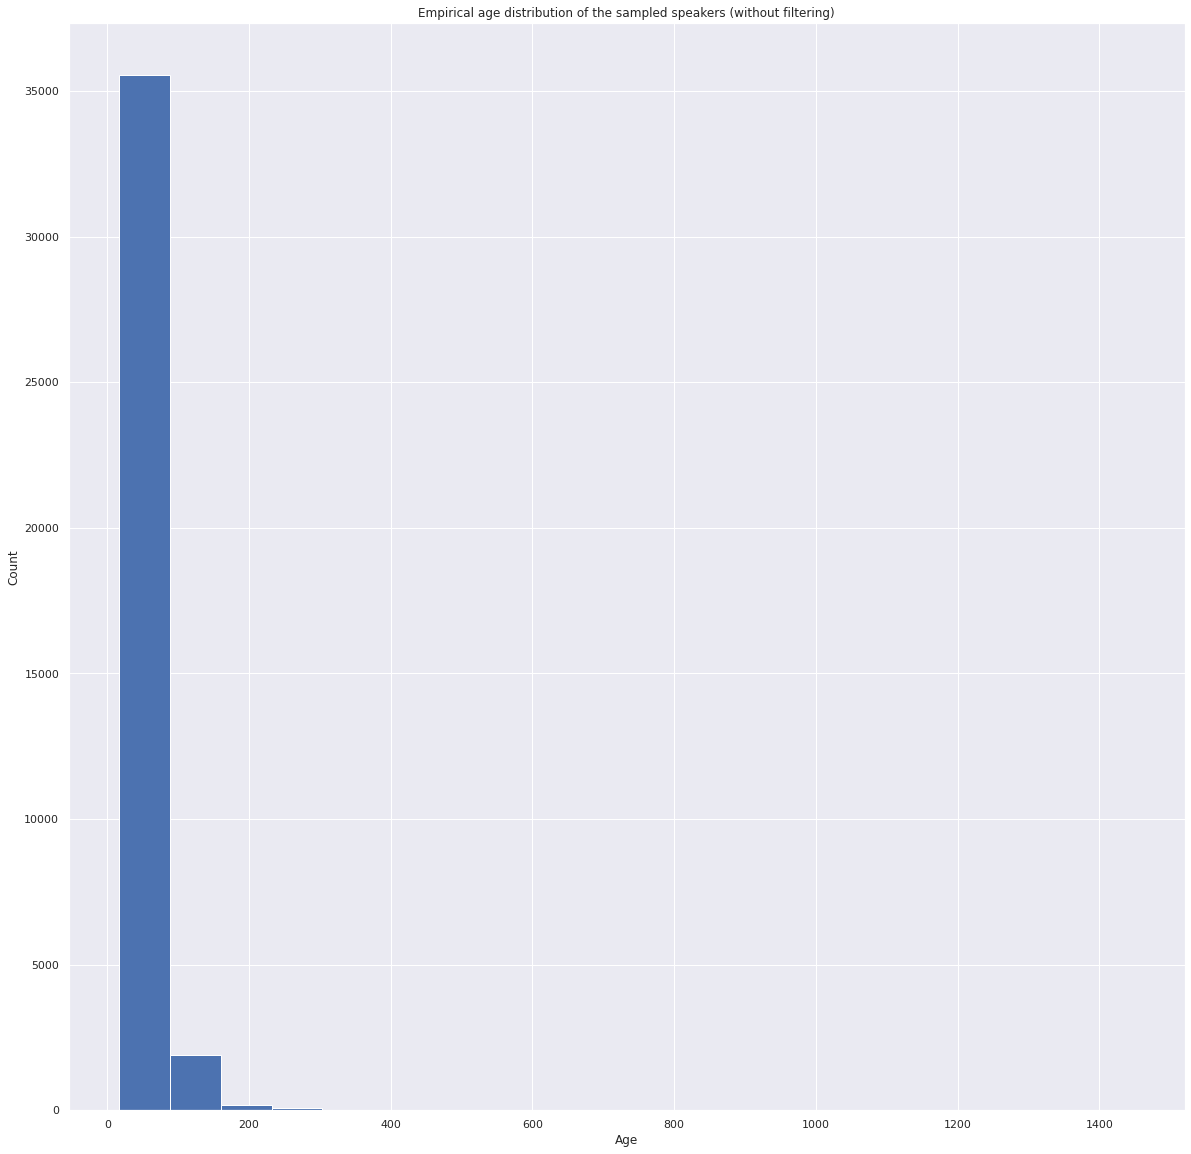

In [56]:
plt.hist(speaker_age.values(), bins=20)
plt.title("Empirical age distribution of the sampled speakers (without filtering)")
plt.xlabel("Age")
plt.ylabel("Count")

## Putting everything together
Combining the guessed age, gender and political affiliation

In [57]:
wing = []
ages = []
gender = []


for speaker in speaker_content:
    if speaker in speaker_age.keys() and speaker in speaker_gender.keys() and speaker in speaker_wing.keys() and speaker_age[speaker]<100:
 
        ages.append(speaker_age[speaker])
        wing.append(speaker_wing[speaker][0])
        gender.append(speaker_gender[speaker])


Text(0, 0.5, 'Count')

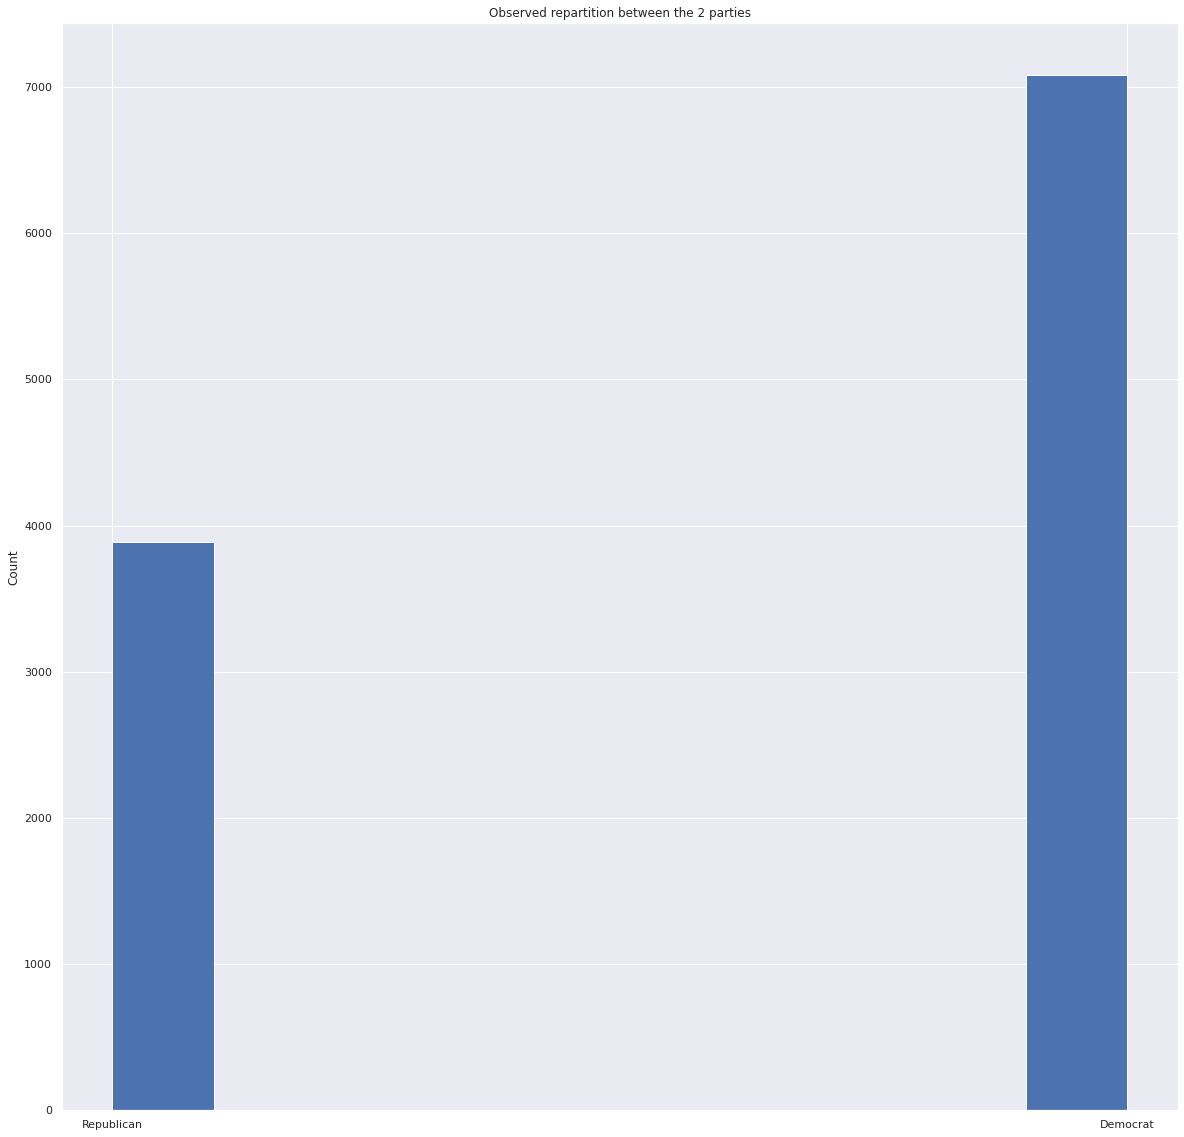

In [58]:
plt.hist(wing)
plt.title("Observed repartition between the 2 parties")
plt.ylabel("Count")

In order to get a more precise view of the age of speakers that could have contributed to the climate change question, we filtered speakers over 100 years old

Text(0, 0.5, 'Count')

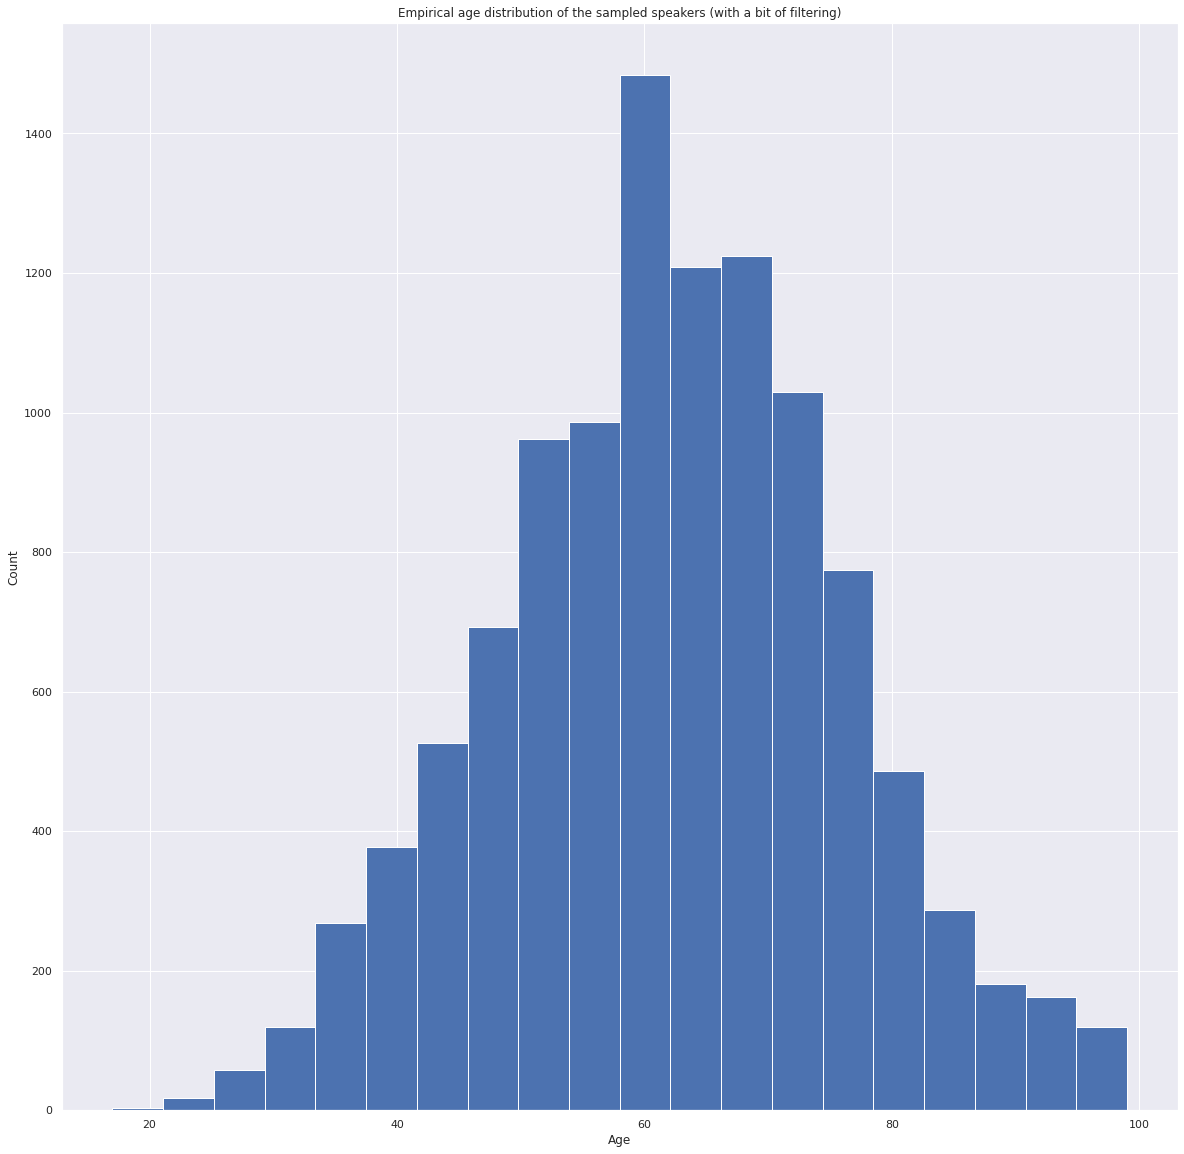

In [59]:
plt.hist(ages,bins=20)
plt.title("Empirical age distribution of the sampled speakers (with a bit of filtering)")
plt.xlabel("Age")
plt.ylabel("Count")

In [60]:
big_dict={}
for speaker in speaker_content:
    if speaker in speaker_age.keys() and speaker in speaker_gender.keys() and speaker in speaker_wing.keys() and speaker_age[speaker]<100:
        big_dict[speaker]=(speaker_age[speaker], speaker_gender[speaker], speaker_wing[speaker][0],speaker_wing[speaker][1])
df = pd.DataFrame.from_dict(big_dict, orient="index", columns=["age", "gender", "wing", "political_count"])
df.wing = df.wing.astype( "category")
df.gender = df.gender.astype("category")

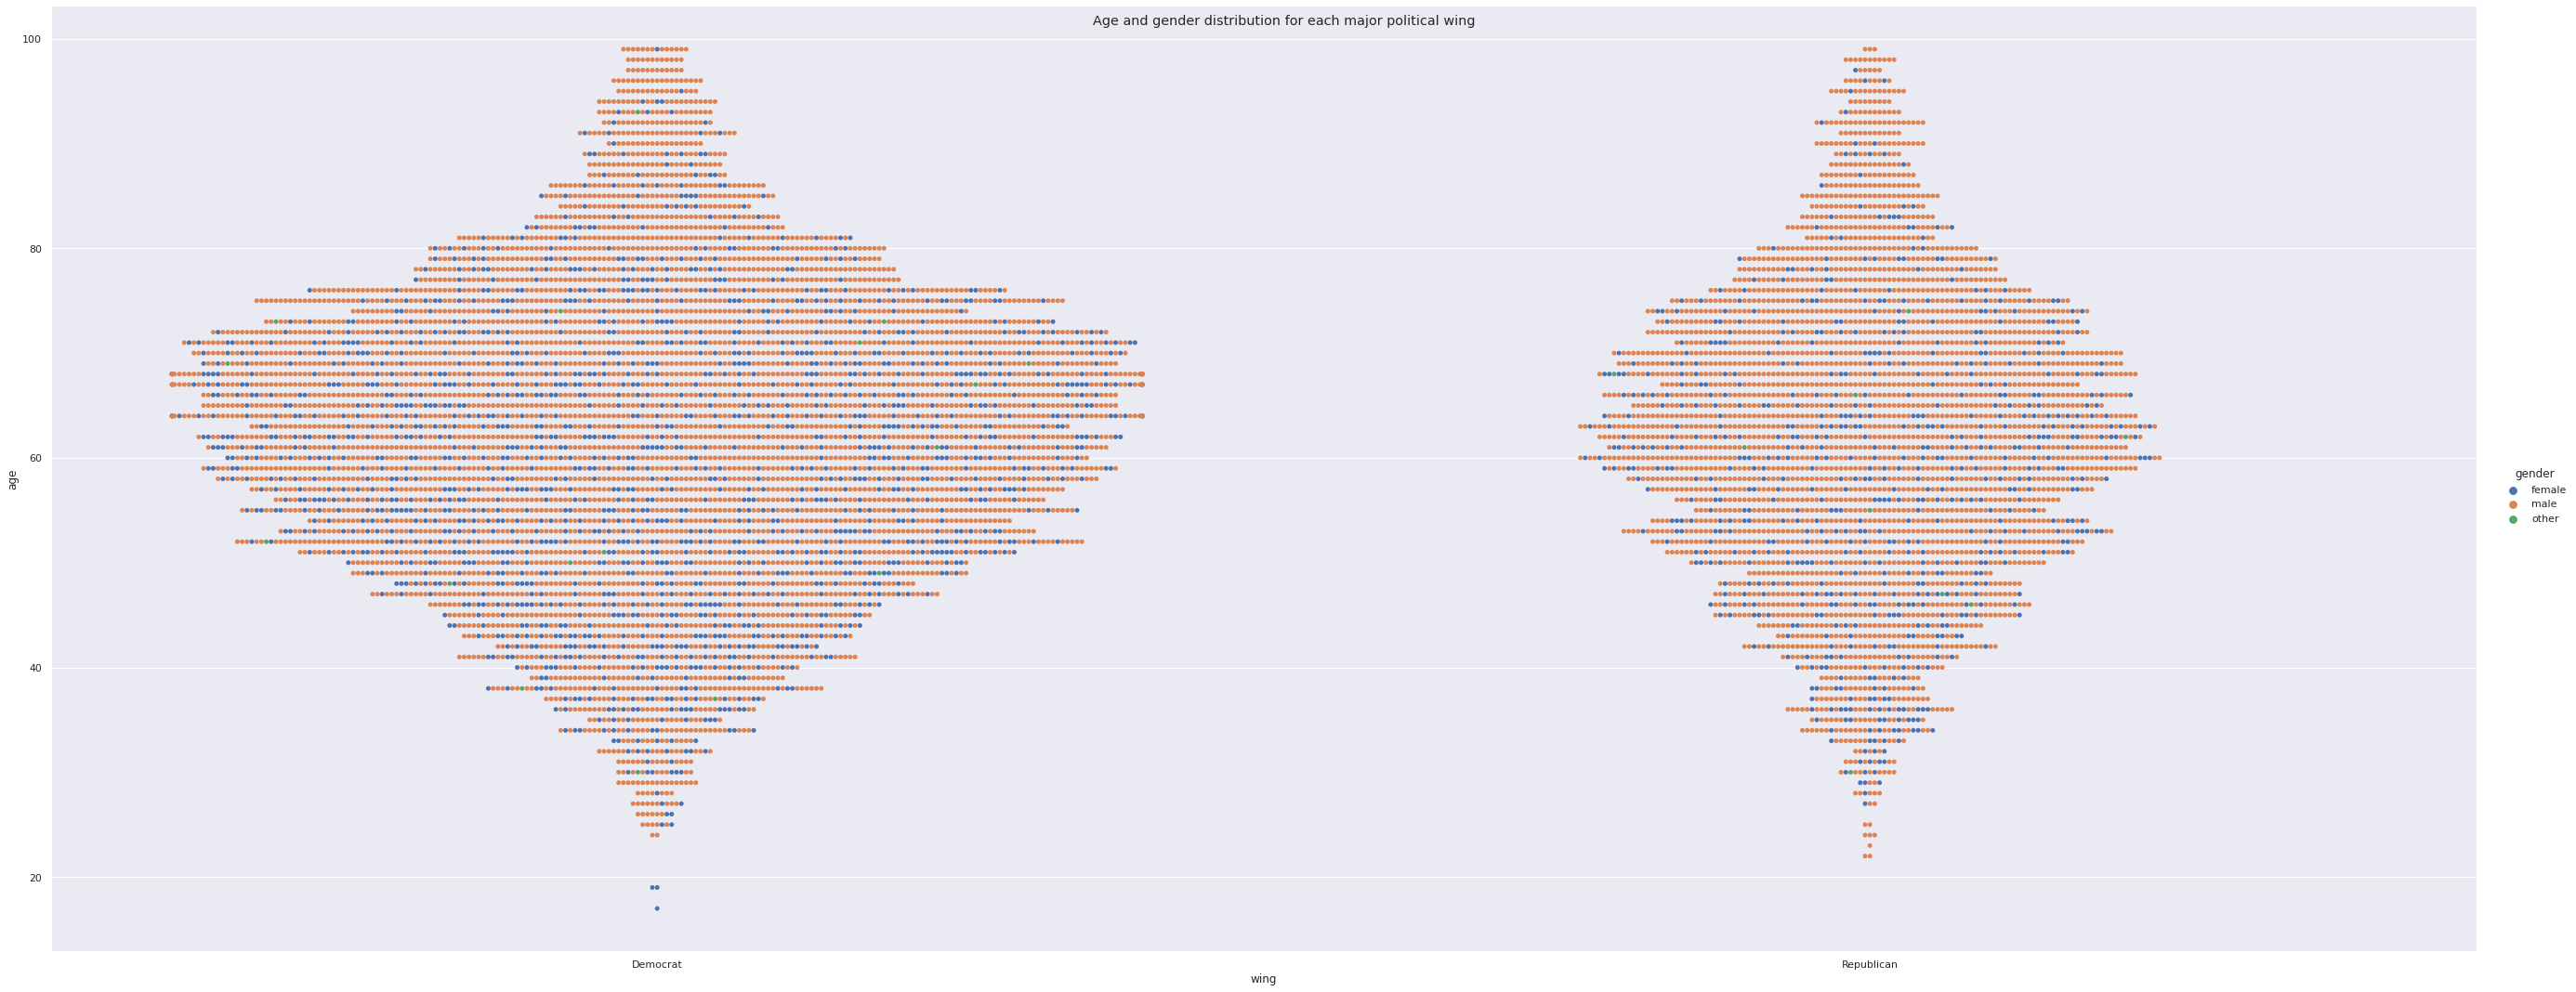

In [61]:
sns.set(rc={'figure.figsize':(20,20)})
sns.catplot(x="wing", y="age", hue="gender", kind="swarm", data=df, height=15, aspect=2.5).fig.suptitle("Age and gender distribution for each major political wing")
ax = plt.gca()
ax
plt.savefig('demographics.png', dpi=300)    

In [82]:
SMALL_SIZE = 25
MEDIUM_SIZE = 30
BIGGER_SIZE = 35

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

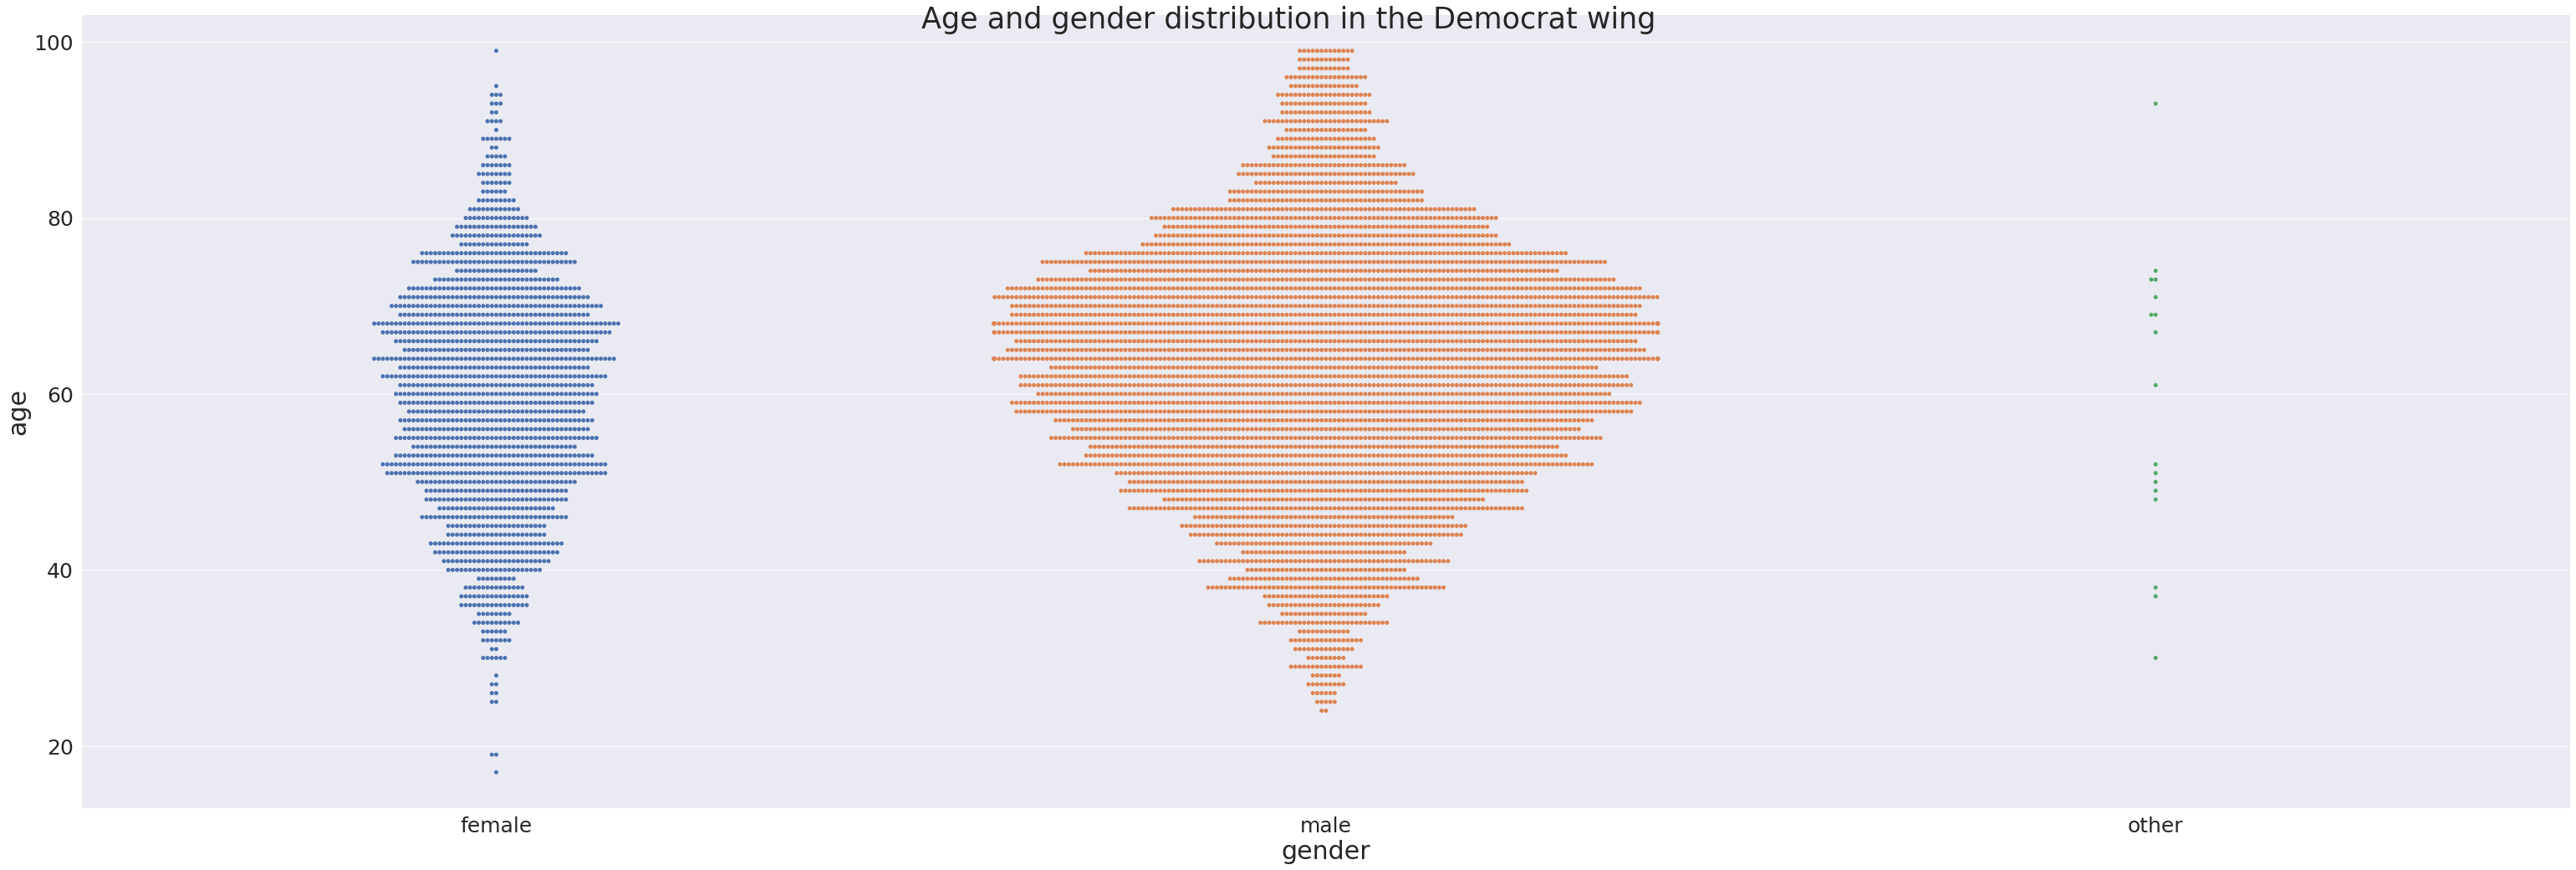

In [87]:
sns.catplot(x="gender",y="age", hue="gender", kind="swarm", data=df[df["wing"]=="Democrat"], height=15, aspect=2.9).fig.suptitle("Age and gender distribution in the Democrat wing")
plt.savefig('demographics_democrats.png', dpi=300)    

In [104]:

df_binary = df[(df["wing"]=="Republican") & (df["gender"]!="other")]
df_binary.gender=df_binary.gender.cat.remove_categories("other")
df_binary.gender

/home/lucastrg/FLEP/MA1/ADA/ada-2021-project-adada-sur-mon-bidet/env/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Charles Boustany     male
Gari Cappelli        male
Jim Mattis           male
Etienne Schneider    male
James Baldwin        male
                     ... 
Willie Geist         male
Gene Green           male
Denis Paradis        male
Carl Heastie         male
Vincent Fort         male
Name: gender, Length: 10944, dtype: category
Categories (2, object): ['female', 'male']

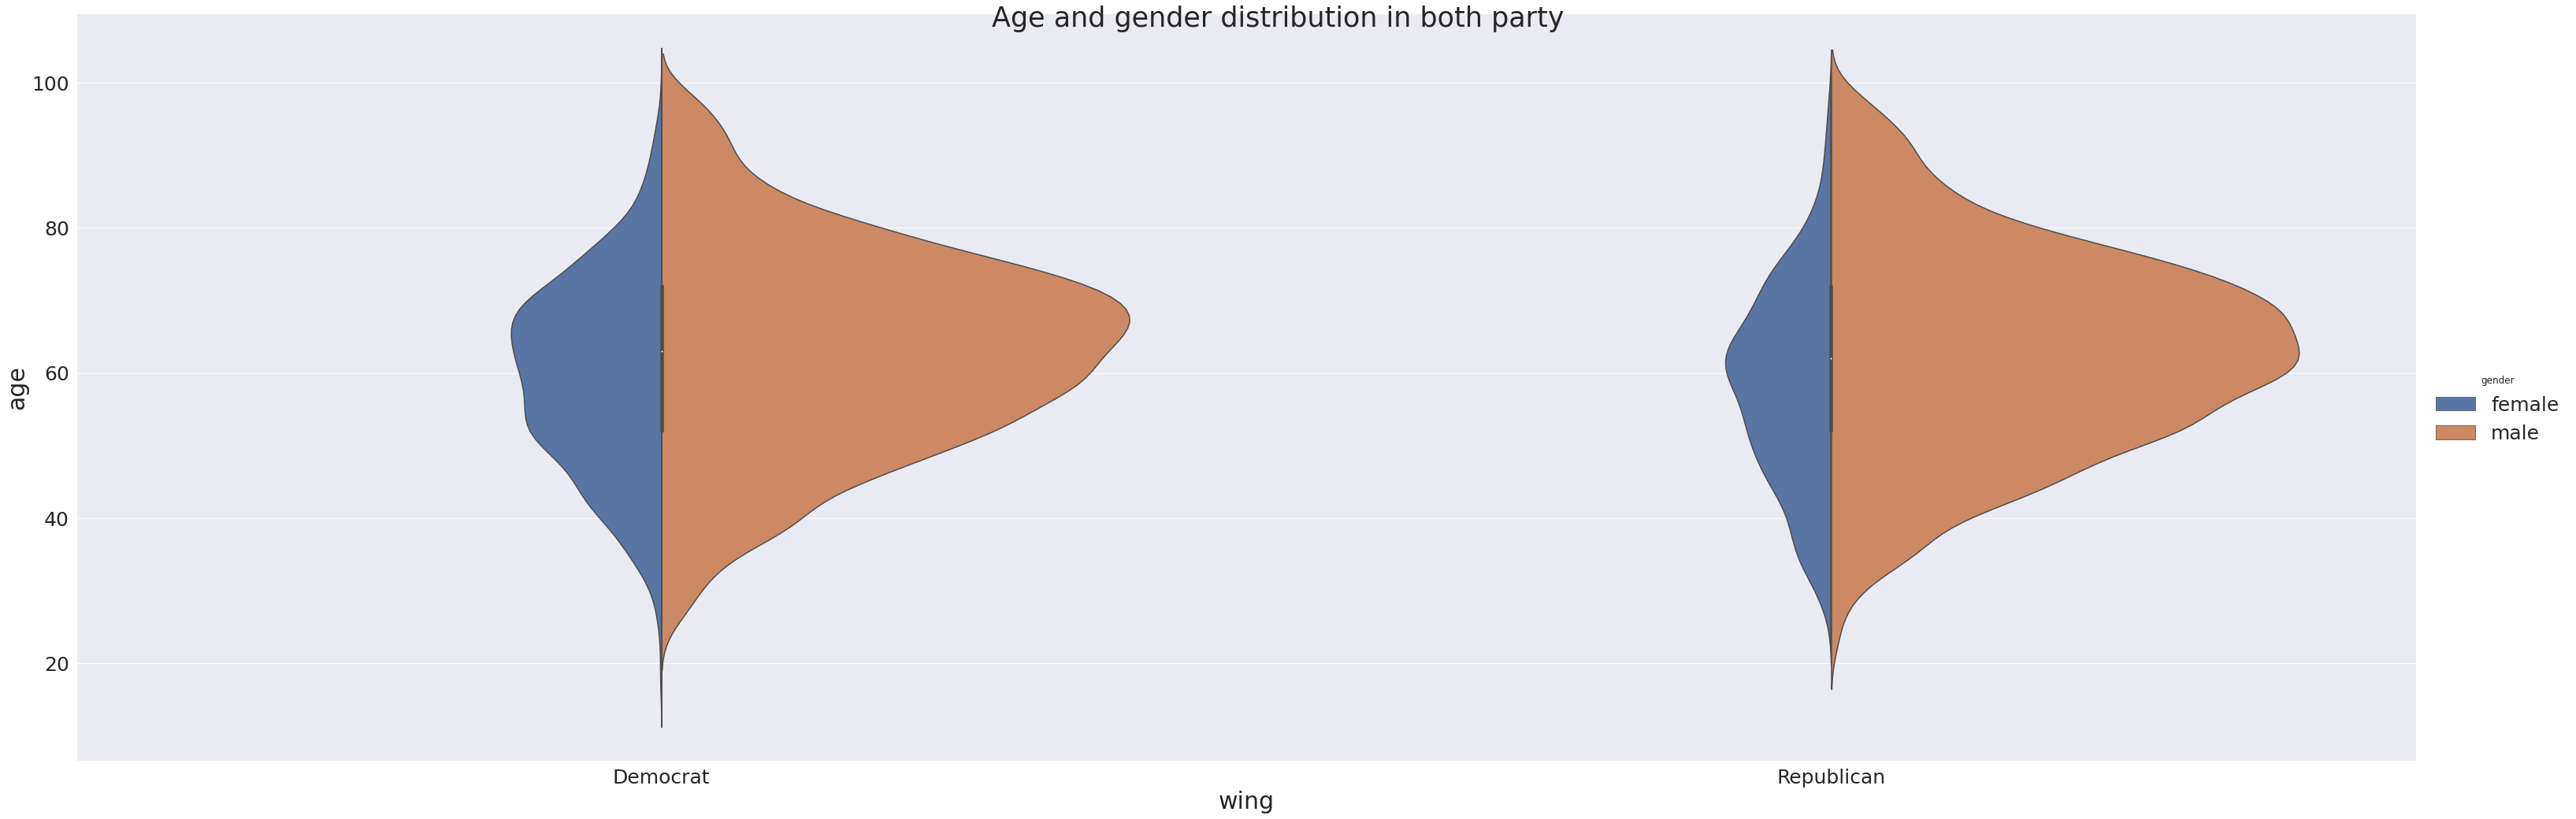

In [111]:
sns.catplot(x="wing", y="age", hue="gender", kind="violin", scale="count",split=True,data=df_binary, height=15, aspect=2.9).fig.suptitle("Age and gender distribution in both party")
plt.savefig('demographics_splitted.png', dpi=300)    

In [63]:
df

,age,gender,wing,political_count
Charles Boustany,66,male,Republican,31
Gari Cappelli,61,male,Democrat,-1
Jim Mattis,72,male,Democrat,3
Etienne Schneider,51,male,Democrat,1
James Baldwin,98,male,Democrat,8
...,...,...,...,...
Willie Geist,47,male,Republican,1
Gene Green,75,male,Democrat,11
Denis Paradis,73,male,Democrat,-1
Carl Heastie,55,male,Democrat,11


In [64]:
df[df.index == "Donald Trump"]

,age,gender,wing,political_count
Donald Trump,76,male,Republican,-1


Text(0.5, 1.0, 'Age distribution of each major political wing')

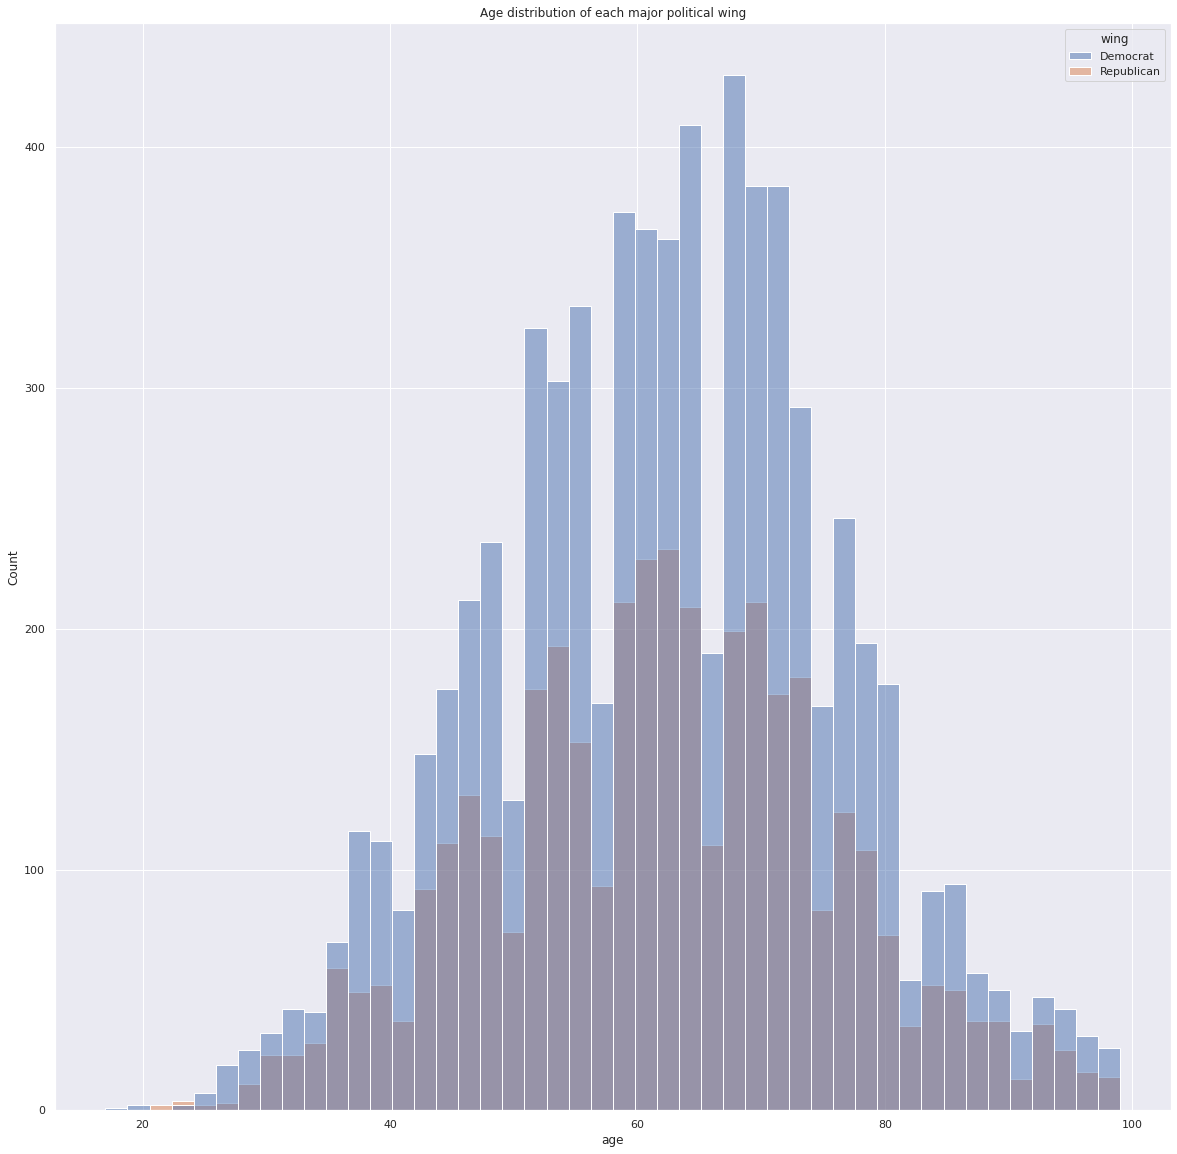

In [65]:
sns.histplot(data=df, x="age", hue="wing").set_title("Age distribution of each major political wing")

Text(0.5, 1.0, 'Age distribution of each assigned gender')

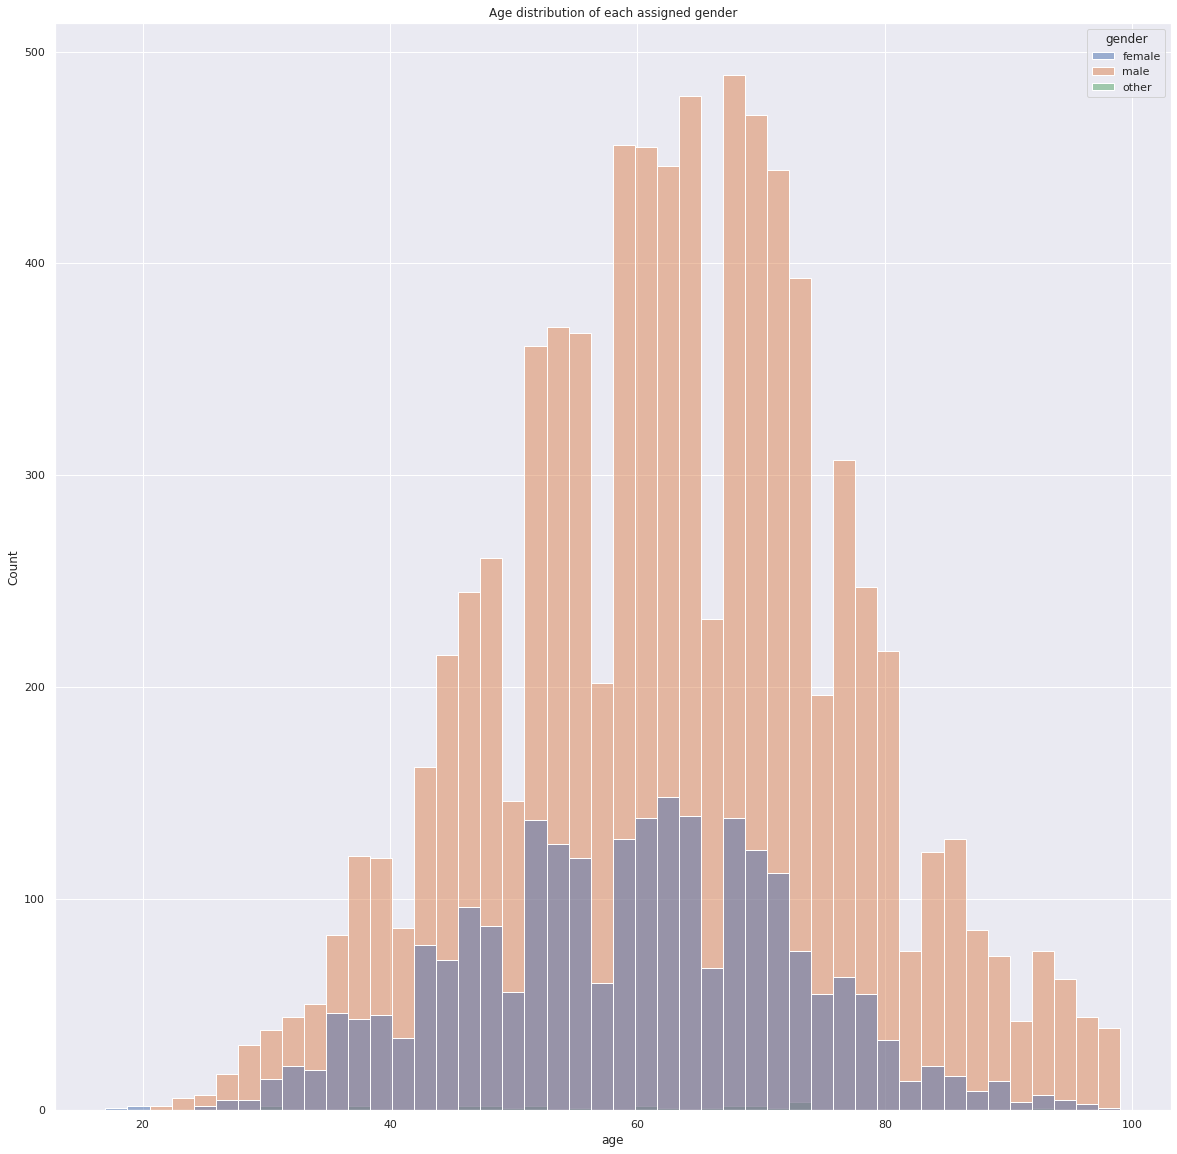

In [66]:
sns.histplot(data=df, x="age", hue="gender").set_title("Age distribution of each assigned gender")

In [67]:
df[(df["wing"]=="Democrat") & (df["gender"]=="male")].describe()

,age,political_count
count,5346.000000,5346.000000
mean,62.979611,5.810325
std,14.077753,14.936934
min,24.000000,-1.000000
25%,53.000000,-1.000000
50%,64.000000,2.000000
75%,72.000000,6.000000
max,99.000000,335.000000


In [68]:
df[(df["wing"]=="Democrat") & (df["gender"]=="female")].describe()

,age,political_count
count,1720.000000,1720.000000
mean,59.623837,4.894186
std,12.976006,11.602710
min,17.000000,-1.000000
25%,51.000000,-1.000000
50%,60.000000,2.000000
75%,69.000000,5.000000
max,99.000000,132.000000


In [69]:
df[(df["wing"]=="Republican") & (df["gender"]=="female")].describe()

,age,political_count
count,716.000000,716.000000
mean,58.314246,6.583799
std,13.387098,18.044776
min,27.000000,-1.000000
25%,49.000000,-1.000000
50%,59.000000,1.000000
75%,68.000000,5.000000
max,97.000000,158.000000


In [70]:
df[(df["wing"]=="Republican") & (df["gender"]=="male")].describe()

,age,political_count
count,3162.000000,3162.000000
mean,62.815623,7.833966
std,14.027423,19.303040
min,22.000000,-1.000000
25%,53.000000,-1.000000
50%,63.000000,2.000000
75%,72.000000,7.000000
max,99.000000,218.000000


In [71]:
716.000000/3162.000000

0.22643896268184693

In [72]:
df[(df["wing"]=="Democrat")].describe()

,age,political_count
count,7083.000000,7083.000000
mean,62.155443,5.580827
std,13.897931,14.186500
min,17.000000,-1.000000
25%,52.000000,-1.000000
50%,63.000000,2.000000
75%,72.000000,6.000000
max,99.000000,335.000000


In [73]:
df[(df["wing"]=="Republican")].describe()

,age,political_count
count,3887.000000,3887.000000
mean,61.971958,7.594289
std,14.018791,19.060912
min,22.000000,-1.000000
25%,52.000000,-1.000000
50%,62.000000,2.000000
75%,72.000000,6.000000
max,99.000000,218.000000


In [74]:
df.describe()

,age,political_count
count,10970.000000,10970.000000
mean,62.090428,6.294257
std,13.940512,16.111478
min,17.000000,-1.000000
25%,52.000000,-1.000000
50%,62.000000,2.000000
75%,72.000000,6.000000
max,99.000000,335.000000
